In [1]:
# image processing imports
from ipfml.processing.segmentation import divide_in_blocks
from ipfml.processing import transform
from ipfml import utils
from PIL import Image
from scipy import signal
from skimage import color
import cv2
import scipy.stats as stats

# display imports
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# main imports
import numpy as np
import os

In [2]:
data_folder = "../dataset"

# Plane filter analysis

## Utils functions definition

In [3]:
def compute_images_path(dict_data):
    
    scene = dict_data['name']
    prefix = dict_data['prefix']
    indices = dict_data['indices']
    
    images_path = []
    for index in indices:
        path = os.path.join(data_folder, os.path.join(scene, prefix + index + ".png"))
        print(path)
        images_path.append(path)
    return images_path

In [4]:
def get_images_zones(dict_data, images_path):
    
    id_zone = dict_data['zone']
    
    zones_img = []
    for path in images_path:
        img = Image.open(path)
        zones = divide_in_blocks(img, (200, 200))
        zones_img.append(zones[id_zone])
        
    return zones_img

## Scenes information data

In [5]:
# start 00020 - ref 00900 - step 10
dict_appart = {'name': 'Appart1opt02', 
               'prefix': 'appartAopt_', 
               'indices': ["00050", "00100", "00200", "00300", "00400", "00600", "00700", "00800", "00900"],
               'zone': 9}

# start 00050 - ref 01200 - step 10
dict_cuisine = {'name': 'Cuisine01', 
               'prefix': 'cuisine01_', 
               'indices': ["00050", "00100", "00200", "00300", "00400", "00600", "00700", "00800", "00900", "01000", "01100", "01200"],
               'zone': 6}

# start 00020 - ref 00950 - step 10
dict_sdb_c = {'name': 'SdbCentre', 
               'prefix': 'SdB2_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 3}

# start 00020 - ref 00950 - step 10
dict_sdb_d = {'name': 'SdbDroite', 
               'prefix': 'SdB2_D_', 
               'indices': ["00020", "00400", "00950"],
               'zone': 3}

### Definition of parameters

In [6]:
images_path_appart = compute_images_path(dict_appart)
images_path_cuisine = compute_images_path(dict_cuisine)

../dataset/Appart1opt02/appartAopt_00050.png
../dataset/Appart1opt02/appartAopt_00100.png
../dataset/Appart1opt02/appartAopt_00200.png
../dataset/Appart1opt02/appartAopt_00300.png
../dataset/Appart1opt02/appartAopt_00400.png
../dataset/Appart1opt02/appartAopt_00600.png
../dataset/Appart1opt02/appartAopt_00700.png
../dataset/Appart1opt02/appartAopt_00800.png
../dataset/Appart1opt02/appartAopt_00900.png
../dataset/Cuisine01/cuisine01_00050.png
../dataset/Cuisine01/cuisine01_00100.png
../dataset/Cuisine01/cuisine01_00200.png
../dataset/Cuisine01/cuisine01_00300.png
../dataset/Cuisine01/cuisine01_00400.png
../dataset/Cuisine01/cuisine01_00600.png
../dataset/Cuisine01/cuisine01_00700.png
../dataset/Cuisine01/cuisine01_00800.png
../dataset/Cuisine01/cuisine01_00900.png
../dataset/Cuisine01/cuisine01_01000.png
../dataset/Cuisine01/cuisine01_01100.png
../dataset/Cuisine01/cuisine01_01200.png


In [7]:
zones_appart = get_images_zones(dict_appart, images_path_appart)
zones_cuisine = get_images_zones(dict_cuisine, images_path_cuisine)

In [8]:
# return residual information
def plane_kernel_filter(window):
    
    width, height = window.shape

    # prepare data
    nb_elem = width * height
    xs = [int(i/height) for i in range(nb_elem)]
    ys = [i%height for i in range(nb_elem)]
    zs = np.array(window).flatten().tolist()

    # get residual (error) from mean plane computed
    tmp_A = []
    tmp_b = []

    for i in range(len(xs)):
        tmp_A.append([xs[i], ys[i], 1])
        tmp_b.append(zs[i])

    b = np.matrix(tmp_b).T
    A = np.matrix(tmp_A)

    fit = (A.T * A).I * A.T * b

    errors = b - A * fit
    residual = np.linalg.norm(errors)

    return residual


# return difference between min and max errors
def plane_kernel_filter_max_error(window):
    
    width, height = window.shape

    # prepare data
    nb_elem = width * height
    xs = [int(i/height) for i in range(nb_elem)]
    ys = [i%height for i in range(nb_elem)]
    zs = np.array(window).flatten().tolist()

    # get residual (error) from mean plane computed
    tmp_A = []
    tmp_b = []

    for i in range(len(xs)):
        tmp_A.append([xs[i], ys[i], 1])
        tmp_b.append(zs[i])

    b = np.matrix(tmp_b).T
    A = np.matrix(tmp_A)

    fit = (A.T * A).I * A.T * b

    errors = b - A * fit
    residual = np.linalg.norm(errors)
    
    errors = abs(np.array(errors))

    return (errors.max() - errors.min())


def plane_custom_filter(img, kernel=(5, 5)):
    
    img = np.array(img)
    
    width, height = img.shape
    
    kernel_width, kernel_height = kernel
    
    if kernel_width % 2 == 0 or kernel_height % 2 == 0:
        raise ValueError("Invalid kernel size, need to be of odd size")
        
    padding_height = (kernel_width - 1) / 2
    padding_width = (kernel_width - 1) / 2
    
    img_plane_error = []
    for i in range(width):
        
        if i >= padding_width and i < (width - padding_width):
            
            row_plane_error = []
            
            for j in range (height):
                
                if j >= padding_height and j < (height - padding_height):
                    
                    # pixel in the center of kernel window size, need to extract window from img
                    window = img[int(i-padding_width):int(i+padding_width + 1), int(j-padding_height):int(j+padding_height + 1)]
                    
                    diff = plane_kernel_filter(window)
                    row_plane_error.append(diff)
                    
            img_plane_error.append(row_plane_error)
        
    return np.array(img_plane_error)

In [22]:
def apply_on_zone(zone):
    
    sub_zones = divide_in_blocks(zone, (20, 20))

    error_list = []

    for sub_zone in sub_zones:
        l_img = transform.get_LAB_L(sub_zone)
        plane_error = plane_custom_filter(utils.normalize_2D_arr(l_img), (5, 5))
        global_diff = np.std(plane_error)
        error_list.append(plane_error)

    error_list = np.array(error_list)
    score = np.std(error_list[0:int(len(sub_zones)/5)])
    print(score)
    
def apply_on_zone_plane_normed(zone, kernel=(5, 5)):
    
    l_img = transform.get_LAB_L(zone)
    
    plane_error = plane_custom_filter(utils.normalize_2D_arr(l_img), kernel)
    return np.mean(plane_error)
    
def apply_on_zone_plane(zone, kernel=(5, 5)):
    
    l_img = transform.get_LAB_L(zone)
    
    plane_error = plane_custom_filter(l_img, kernel)
    return np.mean(plane_error)

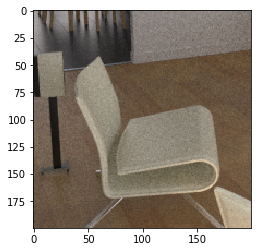

In [10]:
plt.imshow(zones_appart[0])

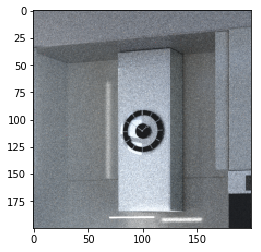

In [11]:
plt.imshow(zones_cuisine[0])

In [18]:
def display_computed_data(zones, dict_scene):
    
    errors = []
    errors_normed = []
    
    print("---------------------------------------------------------------------------------------")
    print("Compute error on " + dict_scene["name"] + " scene (zone " + str(dict_scene["zone"]) + ")") 
    
    for index, zone in enumerate(zones):
        plane_mean_error = apply_on_zone_plane(zone)
        plane_mean_error_normed = apply_on_zone_plane_normed(zone)
    
        errors.append(plane_mean_error)
        errors_normed.append(plane_mean_error_normed)
        
        print(dict_scene["prefix"] +dict_scene["indices"][index], "=> score","{0:.8f}".format(plane_mean_error),"| normed :","{0:.8f}".format(plane_mean_error_normed))
        
    return errors, errors_normed

In [24]:
appart_errors = display_computed_data(zones_appart, dict_appart)
cuisine_errors = display_computed_data(zones_cuisine, dict_cuisine)

---------------------------------------------------------------------------------------
Compute error on Appart1opt02 scene (zone 9)
appartAopt_00050 => score 13.30254427 | normed : 0.15702255
appartAopt_00100 => score 11.09155512 | normed : 0.13641112
appartAopt_00200 => score 9.53841914 | normed : 0.11535671
appartAopt_00300 => score 8.93721088 | normed : 0.10914040
appartAopt_00400 => score 8.57067712 | normed : 0.10599665
appartAopt_00600 => score 8.16948645 | normed : 0.10148266
appartAopt_00700 => score 8.04385333 | normed : 0.09958658
appartAopt_00800 => score 7.96053962 | normed : 0.09888709
appartAopt_00900 => score 7.89593901 | normed : 0.09808461
---------------------------------------------------------------------------------------
Compute error on Cuisine01 scene (zone 6)
cuisine01_00050 => score 14.26744032 | normed : 0.15361529
cuisine01_00100 => score 11.91046744 | normed : 0.12842483
cuisine01_00200 => score 10.20911653 | normed : 0.11054688
cuisine01_00300 => score 9.

## Performance indication

In [23]:
first_zone = zones_appart[0]
%timeit plane_error_img = apply_on_zone_plane(first_zone, kernel=(3, 3))
%timeit plane_error_img = apply_on_zone_plane(first_zone, kernel=(5, 5))
%timeit plane_error_img = apply_on_zone_plane(first_zone, kernel=(7, 7))

8.48 s ± 267 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.66 s ± 293 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.56 s ± 679 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
